In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from scipy.misc import imread
import pickle
import cv2
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_context("poster")

In [3]:
# this file is used to process the raw output of recording training data from the simulator
# and prepare it for uploading to the AWS GPU

folder_to_process = "output"
print("Processing ", folder_to_process)


def extract_data(folder):
    X = [] #images
    XX = [] #senor data (aka speed in this case)
    y = [] #actual steering angles (throttle in the future)


    with open('/Users/watson/output/_data.csv') as f:
        reader = csv.reader(f)

        for line in reader:
            img_file_center = "{}_{}".format(int(line[0]),line[-1])

            X.append(imread('/Users/watson/output/{}.jpg'.format(img_file_center)))
            XX.append([float(line[1])/100]) #throttle is -100 to 100
            y.append([float(line[2])/45]) # steering is -45 to 45

    return (np.array(X), np.array(XX), np.array(y))


X_train, XX_train, y_train = extract_data(folder_to_process)

print("--done--")

Processing  output
--done--


In [4]:
def pipeline(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)

#     # equalize the histogram of the Y channel
#     img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

#     # convert the YUV image back to RGB format
#     img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
#     print(img.shape)

    output = img[200:361,:,:]
    return  cv2.resize(output, (0,0), fx=0.5, fy=0.5)  

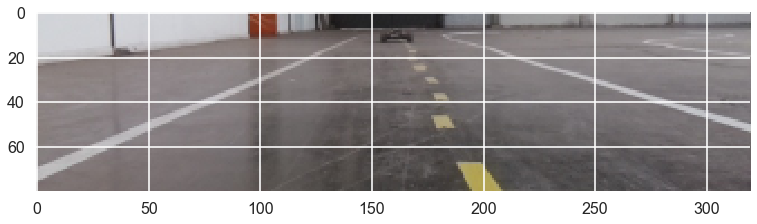

In [5]:
img = X_train[1000]
plt.imshow(pipeline(img))

In [6]:
# reduce image to the road section and apply any transforms in the pipeline
X_train = np.array([pipeline(x) for x in X_train])

In [7]:
X_train.shape

(7085, 80, 320, 3)

In [197]:
# # the following section was used to scrub through the video and find bad sections and remove them
# current_frame = 2210
# scroll_rate = 10


Current Frame:  5670 Steering [ 0.] Throttle [ 0.]


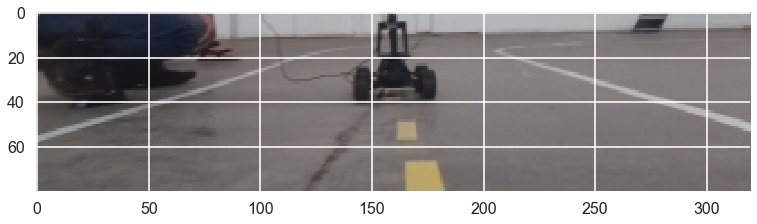

In [545]:
# #scrub through thismanually for bad frames.... ouch time consuming
# print("Current Frame: ", current_frame, "Steering", y_train[current_frame], "Throttle", XX_train[current_frame] )
# plt.imshow(X_train[current_frame])
# current_frame += scroll_rate



In [8]:
#drop bad frames
## bag 1
data_frames_to_drop = [(0,1800), (2080, 2210),(2300, 2590), (2790,2950), 
                       (3400,4060), (4220, 4560), (5110,5230, (5670, 7085))]


clean_indicies = np.ones(len(X_train))
for r in data_frames_to_drop:
    clean_indicies[r[0]:r[1]] = 0

In [9]:
X_cleaned = X_train[clean_indicies.astype(np.bool)]
XX_cleaned = XX_train[clean_indicies.astype(np.bool)]
y_cleaned = y_train[clean_indicies.astype(np.bool)]

print(X_cleaned.shape,XX_cleaned.shape, y_cleaned.shape)

data = {
    "images": X_train,
    "sensors": XX_train,
    "steering_throttle": y_train
}

(3585, 80, 320, 3) (3585, 1) (3585, 1)


In [10]:
import json

In [11]:
with open('vector79_run_1.json', 'w') as f:
    pickle.dump(data, f)


TypeError: Object of type 'ndarray' is not JSON serializable